In [1]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD



import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
import tensorflow as tf
print ("Done")

Done


In [2]:
!pip install libsndfile1

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for libsndfile1: filename=libsndfile1-0.0.1-py3-none-any.whl size=2709 sha256=0e76304d139f71abede85aa245d49c9f7ed28ecec9706d1dcef07aaf857cbe0d
  Stored in directory: /root/.cache/pip/wheels/e5/8a/9e/9a86da679b1069841a6215410e754e0696f7162bdf26bb5d37
Successfully built libsndfile1


# Importing Data

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio
!unzip ravdess-emotional-speech-audio.zip -d ravdess

!kaggle datasets download -d ejlok1/cremad
!unzip cremad.zip -d cremad

!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess
!unzip toronto-emotional-speech-set-tess.zip -d Tess

Streaming output truncated to the last 5000 lines.
  inflating: Tess/TESS Toronto emotional speech set data/OAF_angry/OAF_back_angry.wav  
  inflating: Tess/TESS Toronto emotional speech set data/OAF_angry/OAF_bar_angry.wav  
  inflating: Tess/TESS Toronto emotional speech set data/OAF_angry/OAF_base_angry.wav  
  inflating: Tess/TESS Toronto emotional speech set data/OAF_angry/OAF_bath_angry.wav  
  inflating: Tess/TESS Toronto emotional speech set data/OAF_angry/OAF_bean_angry.wav  
  inflating: Tess/TESS Toronto emotional speech set data/OAF_angry/OAF_beg_angry.wav  
  inflating: Tess/TESS Toronto emotional speech set data/OAF_angry/OAF_bite_angry.wav  
  inflating: Tess/TESS Toronto emotional speech set data/OAF_angry/OAF_boat_angry.wav  
  inflating: Tess/TESS Toronto emotional speech set data/OAF_angry/OAF_bone_angry.wav  
  inflating: Tess/TESS Toronto emotional speech set data/OAF_angry/OAF_book_angry.wav  
  inflating: Tess/TESS Toronto emotional speech set data/OAF_angry/OAF_bought_angry.wav  
  inflating: Tess/TESS Toronto emotional speech set data/OAF_angry/OAF_burn_angry.wav  
  inflating: Tess/TESS Toronto emotional speech set data/OAF_angry/OAF_cab_angry.wav  

In [4]:
ravdess = "/content/ravdess/audio_speech_actors_01-24/"
Crema = "/content/cremad/AudioWAV/"
Tess = "/content/Tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"

# Preprocessing

**Ravdees**

In [5]:
file_emotion = []
file_path = []
ravdess_directory_list = os.listdir(ravdess)
for i in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(ravdess + i)
    for f in actor:
        part = f.split('.')[0].split('-')
    # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + i + '/' + f)

In [6]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)
print(ravdess_df.head())
print("______________________________________________")
print(ravdess_df.tail())
print("_______________________________________________")
print(ravdess_df.Emotions.value_counts())



  Emotions                                               Path
0    happy  /content/ravdess/audio_speech_actors_01-24/Act...
1     fear  /content/ravdess/audio_speech_actors_01-24/Act...
2  disgust  /content/ravdess/audio_speech_actors_01-24/Act...
3     fear  /content/ravdess/audio_speech_actors_01-24/Act...
4  disgust  /content/ravdess/audio_speech_actors_01-24/Act...
______________________________________________
     Emotions                                               Path
1435      sad  /content/ravdess/audio_speech_actors_01-24/Act...
1436  neutral  /content/ravdess/audio_speech_actors_01-24/Act...
1437     fear  /content/ravdess/audio_speech_actors_01-24/Act...
1438     fear  /content/ravdess/audio_speech_actors_01-24/Act...
1439    happy  /content/ravdess/audio_speech_actors_01-24/Act...
_______________________________________________
neutral     288
happy       192
fear        192
disgust     192
angry       192
sad         192
surprise    192
Name: Emotions, dtype: int64


**Crema DataFrame**

In [7]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df.Emotions.value_counts())


disgust    1271
happy      1271
sad        1271
fear       1271
angry      1271
neutral    1087
Name: Emotions, dtype: int64


**TESS dataset**

In [8]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df.Emotions.value_counts())

surprise    400
sad         400
disgust     400
neutral     400
happy       400
angry       400
fear        400
Name: Emotions, dtype: int64


# Integration

In [9]:
data_path = pd.concat([ravdess_df, Crema_df, Tess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,happy,/content/ravdess/audio_speech_actors_01-24/Act...
1,fear,/content/ravdess/audio_speech_actors_01-24/Act...
2,disgust,/content/ravdess/audio_speech_actors_01-24/Act...
3,fear,/content/ravdess/audio_speech_actors_01-24/Act...
4,disgust,/content/ravdess/audio_speech_actors_01-24/Act...


In [10]:
print(data_path.Emotions.value_counts())

happy       1863
fear        1863
disgust     1863
angry       1863
sad         1863
neutral     1775
surprise     592
Name: Emotions, dtype: int64


# Data Visualisation and Exploration

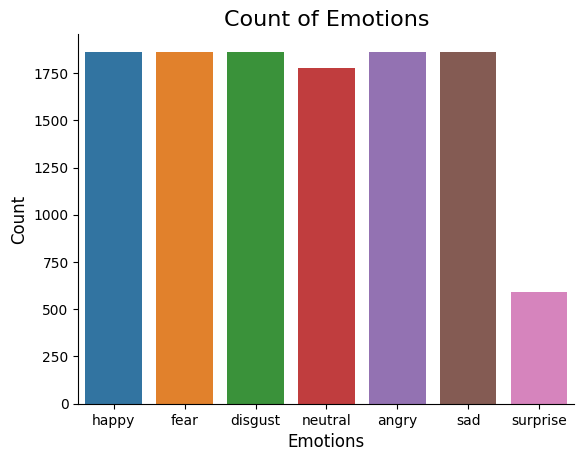

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.title('Count of Emotions', size=16)
sns.countplot(data = data_path, x='Emotions')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [12]:
data,sr = librosa.load(file_path[0])
sr

22050

In [13]:
ipd.Audio(data,rate=sr)

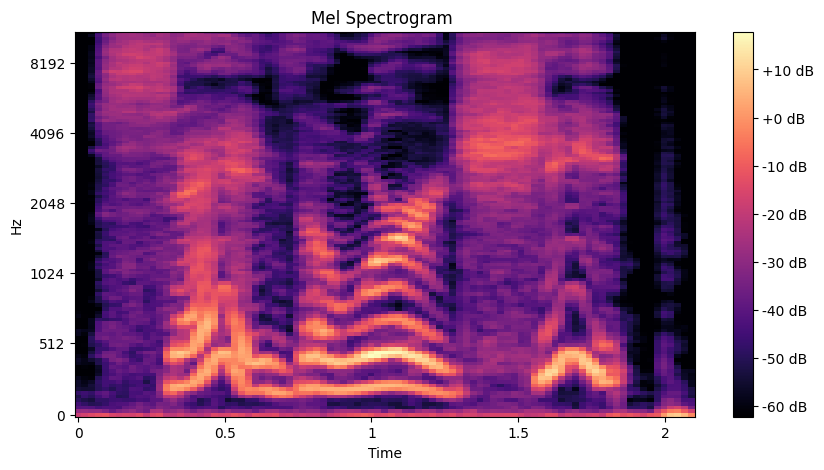

In [14]:
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000)
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')

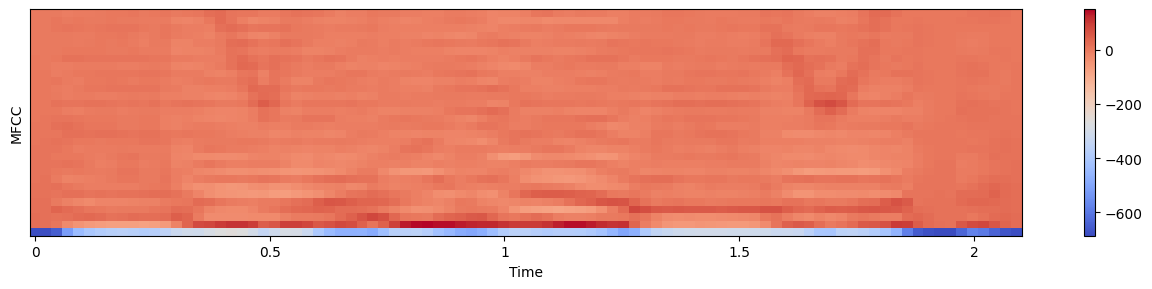

In [16]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)


# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data,rate=sr)

# Data augmentation

In [17]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate = rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = pitch_factor)

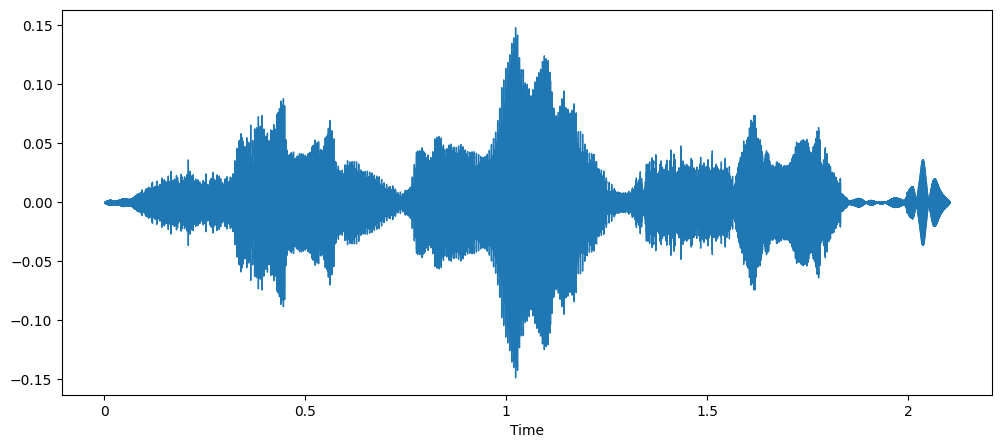

In [18]:
# NORMAL AUDIO


import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data,rate=sr)

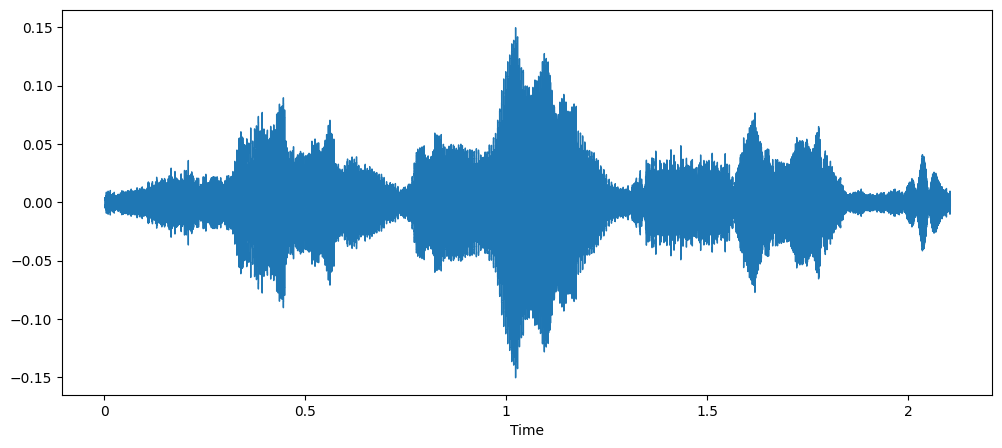

In [19]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

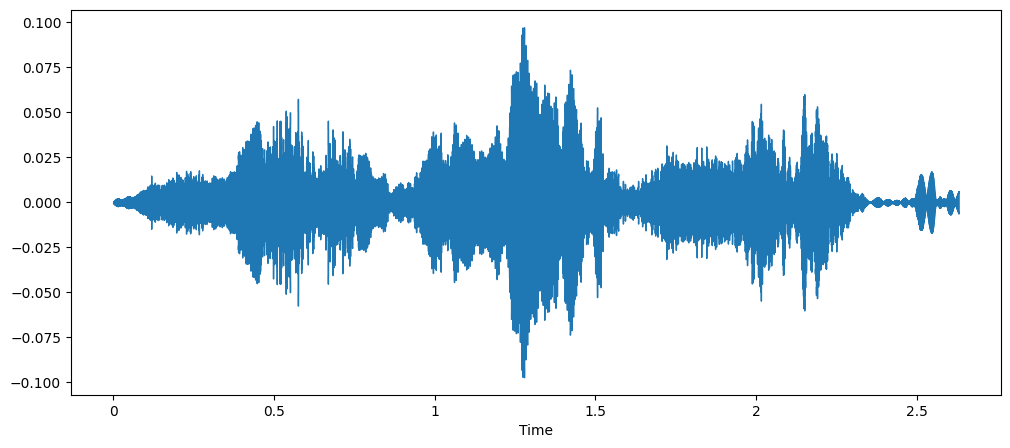

In [20]:
# STRETCHED AUDIO
x = stretch(data)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

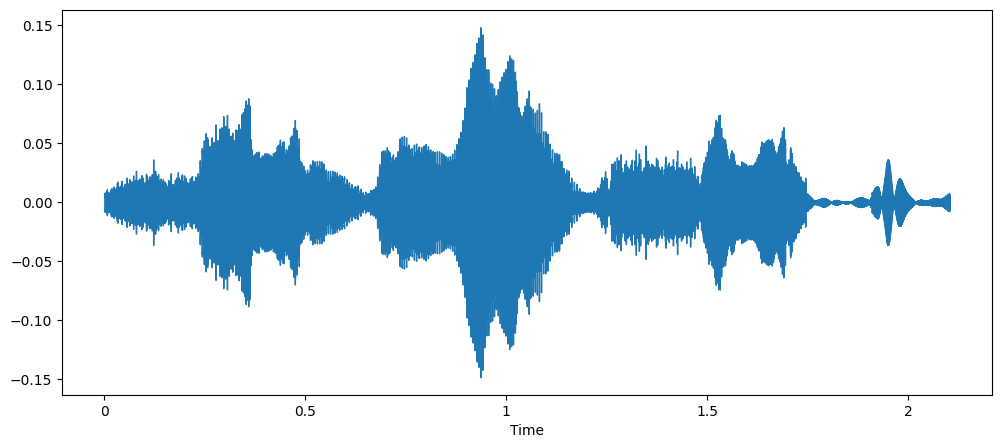

In [21]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

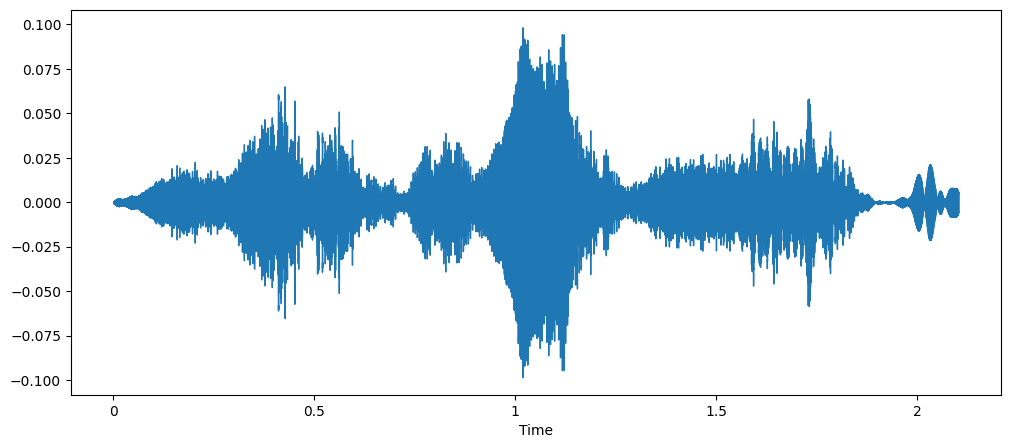

In [22]:
# AUDIO WITH PITCH
x = pitch(data, sr)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

# Feature extraction

In [23]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length = frame_length,hop_length = hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)

    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))

    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))

    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))

    return audio


In [24]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  8


In [25]:
import timeit
from tqdm import tqdm
start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(data_path.Path,data_path.Emotions,range(data_path.Path.shape[0]))):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)

1it [00:00,  5.90it/s]

0 audio has been processed


502it [01:37,  5.31it/s]

500 audio has been processed


1001it [03:16,  4.69it/s]

1000 audio has been processed


1502it [04:54,  6.62it/s]

1500 audio has been processed


2002it [06:16,  6.39it/s]

2000 audio has been processed


2502it [07:34,  6.35it/s]

2500 audio has been processed


3002it [08:55,  5.97it/s]

3000 audio has been processed


3502it [10:15,  6.13it/s]

3500 audio has been processed


4002it [11:34,  5.82it/s]

4000 audio has been processed


4502it [12:54,  5.53it/s]

4500 audio has been processed


5002it [14:13,  6.60it/s]

5000 audio has been processed


5502it [15:34,  6.14it/s]

5500 audio has been processed


6002it [16:55,  6.11it/s]

6000 audio has been processed


6502it [18:12,  6.71it/s]

6500 audio has been processed


7002it [19:33,  6.58it/s]

7000 audio has been processed


7502it [20:52,  6.30it/s]

7500 audio has been processed


8002it [22:14,  7.09it/s]

8000 audio has been processed


8502it [23:33,  6.78it/s]

8500 audio has been processed


9002it [24:50,  7.65it/s]

9000 audio has been processed


9502it [26:04,  7.52it/s]

9500 audio has been processed


10002it [27:17,  8.55it/s]

10000 audio has been processed


10503it [28:20, 10.45it/s]

10500 audio has been processed


11002it [29:13, 10.21it/s]

11000 audio has been processed


11502it [30:17,  6.50it/s]

11500 audio has been processed


11682it [30:46,  6.33it/s]

Done
Time:  1846.743789895


In [26]:
len(X), len(Y), data_path.Path.shape

(46728, 46728, (11682,))

# Saving features

In [27]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.115234,0.170410,0.225586,0.232910,0.226562,0.217773,0.224609,0.237793,0.228027,0.326660,...,2.569661,2.501310,2.430292,2.357252,2.282841,2.207690,2.132418,2.057585,1.983727,happy
1,0.254883,0.376465,0.504395,0.505371,0.511230,0.510742,0.501953,0.490723,0.483398,0.486328,...,-0.728042,1.298059,5.404388,1.738547,-1.355604,-2.261316,-2.417548,4.827300,-0.345245,happy
2,0.106445,0.162598,0.217773,0.221680,0.224609,0.220703,0.212891,0.185547,0.160156,0.156250,...,1.391029,1.334767,1.275885,1.214862,1.152181,1.088326,1.023786,0.959022,0.894487,happy
3,0.243652,0.363770,0.477051,0.471680,0.481934,0.481934,0.500000,0.502930,0.505859,0.514160,...,2.113851,7.362579,1.687137,-1.203067,-4.622868,-2.539475,1.370485,-1.100869,-0.335466,happy
4,0.371094,0.446289,0.501953,0.377441,0.326660,0.375977,0.442383,0.481934,0.505371,0.493652,...,2.541248,2.482412,2.420040,2.354482,2.286101,2.215266,2.142344,2.067717,1.991757,fear


In [28]:
print(Emotions.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [29]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(46728, 2377)

In [30]:
np.sum(Emotions.isna())

0           0
1           0
2           0
3           0
4           0
           ..
2372        0
2373        0
2374        0
2375        0
Emotions    0
Length: 2377, dtype: int64

# Data preparation

In [31]:
X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [32]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [33]:
print(Y.shape)
X.shape

(46728, 7)


(46728, 2376)

In [34]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.4, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((28036, 2376), (28036, 7), (18692, 2376), (18692, 7))

In [36]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((28036, 2376), (28036, 7), (18692, 2376), (18692, 7))

In [37]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

> Applying early stopping


In [38]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)

In [39]:
early_stop=EarlyStopping(monitor='val_accuracy',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

# CNN Model

In [40]:
#Reshape for CNN MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((28036, 2376, 1), (28036, 7), (18692, 2376, 1), (18692, 7))

In [42]:
import tensorflow.keras.layers as L

model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(x_traincnn.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer

    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),


    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer

    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(7,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2376, 512)         3072      
                                                                 
 batch_normalization (Batch  (None, 2376, 512)         2048      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 1188, 512)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 1188, 512)         1311232   
                                                                 
 batch_normalization_1 (Bat  (None, 1188, 512)         2048      
 chNormalization)                                                
                                                        

In [43]:
history=model.fit(x_traincnn, y_train, epochs=50, validation_data=(x_testcnn, y_test), batch_size=64,callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/50
439/439 [==============================] - ETA: 0s - loss: 1.4304 - accuracy: 0.4533

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


439/439 [==============================] - 64s 114ms/step - loss: 1.4304 - accuracy: 0.4533 - val_loss: 1.9150 - val_accuracy: 0.3006 - lr: 0.0010
Epoch 2/50
439/439 [==============================] - 49s 113ms/step - loss: 1.1218 - accuracy: 0.5684 - val_loss: 1.0690 - val_accuracy: 0.5847 - lr: 0.0010
Epoch 3/50
439/439 [==============================] - 49s 112ms/step - loss: 1.0092 - accuracy: 0.6129 - val_loss: 1.0312 - val_accuracy: 0.6069 - lr: 0.0010
Epoch 4/50
439/439 [==============================] - 49s 112ms/step - loss: 0.8789 - accuracy: 0.6667 - val_loss: 0.9339 - val_accuracy: 0.6457 - lr: 0.0010
Epoch 5/50
439/439 [==============================] - 49s 111ms/step - loss: 0.7699 - accuracy: 0.7083 - val_loss: 0.9934 - val_accuracy: 0.6403 - lr: 0.0010
Epoch 6/50
439/439 [==============================] - 49s 112ms/step - loss: 0.6242 - accuracy: 0.7689 - val_loss: 0.8282 - val_accuracy: 0.6985 - lr: 0.0010
Epoch 7/50
439/439 [==============================] - 49s 112ms

585/585 [==============================] - 9s 15ms/step - loss: 0.2980 - accuracy: 0.9364
Accuracy of our model on test data :  93.63899230957031 %


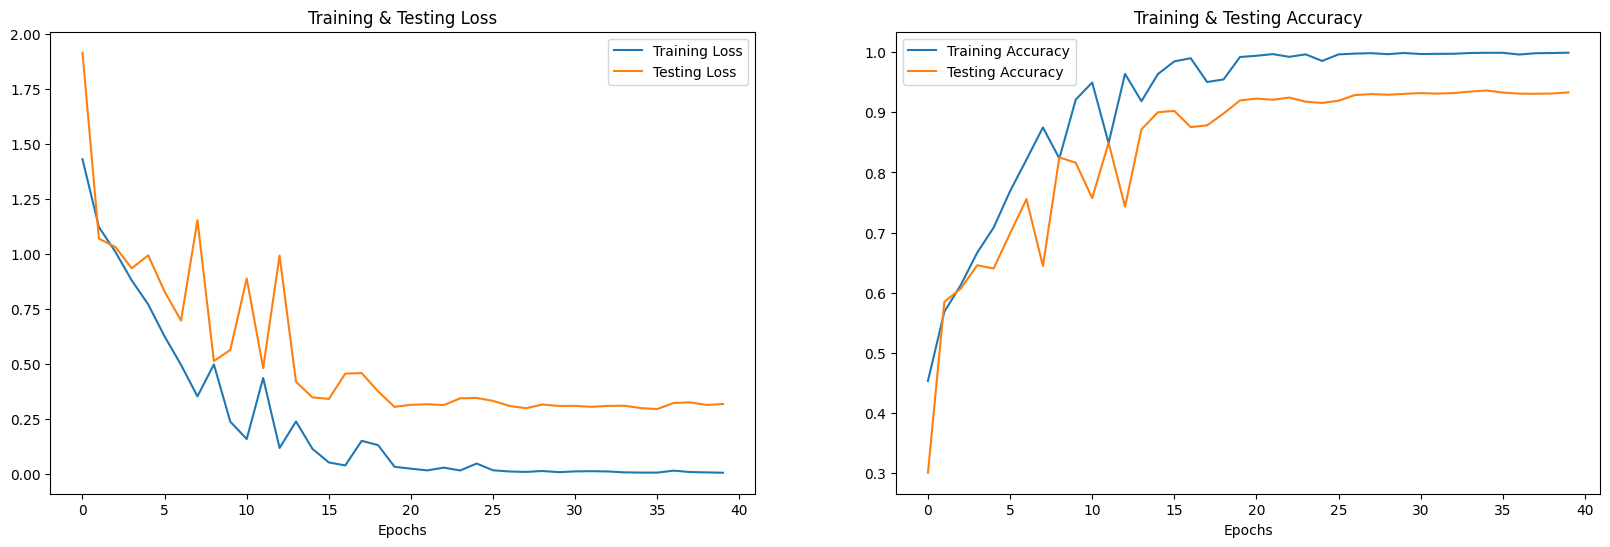

In [44]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

epochs = [i for i in range(len(history.history['accuracy']))]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [45]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

585/585 [==============================] - 8s 12ms/step


,Predicted Labels,Actual Labels
0,angry,angry
1,fear,fear
2,happy,happy
3,disgust,disgust
4,happy,happy
5,disgust,neutral
6,happy,happy
7,happy,happy
8,disgust,disgust
9,fear,fear


# Evalutation

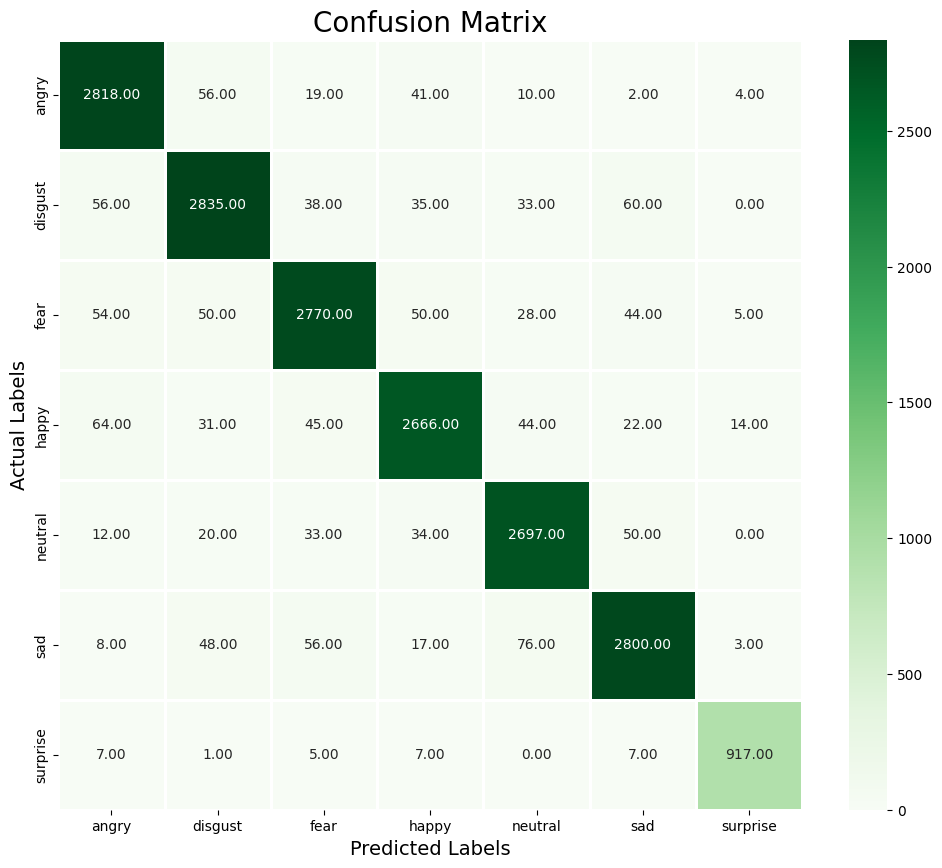

              precision    recall  f1-score   support

       angry       0.93      0.96      0.94      2950
     disgust       0.93      0.93      0.93      3057
        fear       0.93      0.92      0.93      3001
       happy       0.94      0.92      0.93      2886
     neutral       0.93      0.95      0.94      2846
         sad       0.94      0.93      0.93      3008
    surprise       0.97      0.97      0.97       944

    accuracy                           0.94     18692
   macro avg       0.94      0.94      0.94     18692
weighted avg       0.94      0.94      0.94     18692



In [46]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Greens', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))

In [47]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

In [48]:
def get_predict_feat(path):
    d, s_rate= librosa.load(path=path, duration=2.5, offset=0.6)
    res=extract_features(d)
    result=np.array(res)
    result=np.reshape(result,newshape=(1,2376))
    i_result = scaler.transform(result)
    final_result=np.expand_dims(i_result, axis=2)

    return final_result

In [49]:
res=get_predict_feat("/content/ravdess/Actor_01/03-01-07-01-01-01-01.wav")
print(res.shape)

(1, 2376, 1)


In [50]:
emotions1={1:'Neutral', 2:'Neutral', 3:'Happy', 4:'Sad', 5:'Angry', 6:'Fear', 7:'Disgust',8:'Surprise'}
def prediction(path1):
    res=get_predict_feat(path1)
    predictions=model.predict(res)
    y_pred = encoder.inverse_transform(predictions)
    print(y_pred[0][0])

In [61]:
path = "/content/ravdess/Actor_02/03-01-01-01-01-01-02.wav"
prediction(path)
data,sr = librosa.load(path)
ipd.Audio(data,rate=sr)

1/1 [==============================] - 0s 46ms/step
neutral


In [62]:
path = "/content/ravdess/Actor_01/03-01-01-01-01-01-01.wav"
prediction(path)
data,sr = librosa.load(path)
ipd.Audio(data,rate=sr)

1/1 [==============================] - 0s 41ms/step
neutral


In [63]:
path = "/content/ravdess/Actor_01/03-01-05-01-02-02-01.wav"
prediction(path)
data,sr = librosa.load(path)
ipd.Audio(data,rate=sr)

1/1 [==============================] - 0s 37ms/step
angry


In [64]:
path = "/content/ravdess/Actor_21/03-01-04-02-02-02-21.wav"
prediction(path)
data,sr = librosa.load(path)
ipd.Audio(data,rate=sr)

1/1 [==============================] - 0s 30ms/step
sad


In [65]:
path = "/content/ravdess/Actor_02/03-01-06-01-02-02-02.wav"
prediction(path)
data,sr = librosa.load(path)
ipd.Audio(data,rate=sr)

1/1 [==============================] - 0s 43ms/step
fear


In [66]:
path = "/content/ravdess/Actor_01/03-01-08-01-01-01-01.wav"
prediction(path)
data,sr = librosa.load(path)
ipd.Audio(data,rate=sr)

1/1 [==============================] - 0s 31ms/step
surprise


In [67]:
path = "/content/ravdess/Actor_01/03-01-07-01-01-01-01.wav"
prediction(path)
data,sr = librosa.load(path)
ipd.Audio(data,rate=sr)

1/1 [==============================] - 0s 31ms/step
disgust
